In [ ]:
!uv pip install lightgbm
!uv pip install --upgrade hopsworks
!uv pip install --upgrade nannyml
#!uv pip install --upgrade scikit-learn

In [8]:
import pandas as pd
import numpy as np
import hopsworks
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error
from lightgbm import LGBMRegressor, plot_importance

import nannyml as nml

In [9]:
# Read data from url
url = "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2016-12.parquet"
columns = ['lpep_pickup_datetime', 'PULocationID', 'DOLocationID', 'trip_distance', 'VendorID', 'payment_type', 'fare_amount', 'tip_amount']
data = pd.read_parquet(url, columns=columns)

In [10]:
# Choose only payments from Credit Cards
data = data.loc[data['payment_type'] == 1,].drop(columns='payment_type') # Credit card
# Choose only positive tip amounts
data = data[data['tip_amount'] >= 0]

# Sort data by pick up date
data = data.sort_values('lpep_pickup_datetime').reset_index(drop=True)

# Create column with pick up time
data['pickup_time'] = data['lpep_pickup_datetime'].dt.hour
data = data.reset_index()
data

,index,lpep_pickup_datetime,PULocationID,DOLocationID,trip_distance,VendorID,fare_amount,tip_amount,pickup_time
0,0,2016-12-01 00:00:02,82,129,0.60,1,5.0,1.00,0
1,1,2016-12-01 00:00:11,95,135,1.14,2,6.0,2.19,0
2,2,2016-12-01 00:00:16,181,79,6.91,2,22.0,3.50,0
3,3,2016-12-01 00:00:19,25,49,1.50,1,8.0,2.75,0
4,4,2016-12-01 00:00:25,52,181,1.96,2,8.5,1.96,0
...,...,...,...,...,...,...,...,...,...
581829,581829,2016-12-31 23:59:42,216,197,0.90,1,7.0,0.00,23
581830,581830,2016-12-31 23:59:47,256,48,9.02,2,30.5,0.00,23
581831,581831,2016-12-31 23:59:49,42,74,2.48,2,11.0,2.46,23
581832,581832,2016-12-31 23:59:51,42,42,0.54,2,4.0,1.06,23


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581834 entries, 0 to 581833
Data columns (total 9 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   index                 581834 non-null  int64         
 1   lpep_pickup_datetime  581834 non-null  datetime64[us]
 2   PULocationID          581834 non-null  int64         
 3   DOLocationID          581834 non-null  int64         
 4   trip_distance         581834 non-null  float64       
 5   VendorID              581834 non-null  int64         
 6   fare_amount           581834 non-null  float64       
 7   tip_amount            581834 non-null  float64       
 8   pickup_time           581834 non-null  int32         
dtypes: datetime64[us](1), float64(3), int32(1), int64(4)
memory usage: 37.7 MB


In [12]:
# Create data partition
# data['partition'] = pd.cut(
#     data['lpep_pickup_datetime'],
#     bins= [pd.to_datetime('2016-12-01'),
#            pd.to_datetime('2016-12-08'),
#            pd.to_datetime('2016-12-16'),
#            pd.to_datetime('2017-01-01')],
#     right=False,
#     labels= ['train', 'test', 'prod']
# )

In [13]:
proj = hopsworks.login()
fs = proj.get_feature_store()
fg = fs.get_or_create_feature_group("nycgreen",
                                    version=1, 
                                    primary_key=["index"],
                                    event_time="lpep_pickup_datetime"
                                   )
print(proj.name)

2025-04-13 23:21:10,451 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-04-13 23:21:10,460 INFO: Initializing external client
2025-04-13 23:21:10,461 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-04-13 23:21:11,631 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/398
dowlingj


In [14]:
fg.insert(data)

2025-04-13 23:21:18,626 WARNING: FeatureGroupWarning: The ingested dataframe contains upper case letters in feature names: `['PULocationID', 'DOLocationID', 'VendorID']`. Feature names are sanitized to lower case in the feature store.

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/398/fs/335/fg/1435216


Uploading Dataframe: 100.00% |████████████████████████| Rows 581834/581834 | Elapsed Time: 00:21 | Remaining Time: 00:00


Launching job: nycgreen_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/398/jobs/named/nycgreen_1_offline_fg_materialization/executions


(Job('nycgreen_1_offline_fg_materialization', 'SPARK'), None)

In [15]:
select = fg.select_features()

2025-04-13 23:36:47,289 INFO: Using ['pulocationid', 'dolocationid', 'trip_distance', 'vendorid', 'fare_amount', 'tip_amount', 'pickup_time'] from feature group `nycgreen` as features for the query. To include primary key and event time use `select_all`.


In [17]:
fv = fs.get_or_create_feature_view("nycgreen", 
                                   version=1,
                                   labels=['tip_amount'],
                                   query=select
                                  )
                                   

Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/398/fs/335/fv/nycgreen/version/1


In [24]:
X_train, X_val, X_test, y_train, y_val, y_test = fv.train_validation_test_split(
    train_start="2016-12-01",
    train_end="2016-12-08",
    validation_start='2016-12-09',
    validation_end='2016-12-16',
    test_start='2016-12-16',
    test_end='2017-01-01'
)

2025-04-13 23:45:15,319 ERROR: Peer dowlingj__dowlingj is not known. Please register client certificates first.. Detail: Python exception: FlyingDuckException. gRPC client debug context: UNKNOWN:Error received from peer ipv4:51.79.26.27:5005 {created_time:"2025-04-13T23:45:15.31665004+02:00", grpc_status:2, grpc_message:"Peer dowlingj__dowlingj is not known. Please register client certificates first.. Detail: Python exception: FlyingDuckException"}. Client context: IOError: Server never sent a data message. Detail: Internal
Traceback (most recent call last):
  File "/home/jdowling/anaconda3/envs/book/lib/python3.10/site-packages/hsfs/core/arrow_flight_client.py", line 394, in afs_error_handler_wrapper
    return func(instance, *args, **kw)
  File "/home/jdowling/anaconda3/envs/book/lib/python3.10/site-packages/hsfs/core/arrow_flight_client.py", line 459, in read_query
    return self._get_dataset(
  File "/home/jdowling/anaconda3/envs/book/lib/python3.10/site-packages/retrying.py", lin

In [25]:
X_train

,pulocationid,dolocationid,trip_distance,vendorid,fare_amount,pickup_time
1,80,62,5.42,2,20.5,22
10,134,197,1.50,1,8.0,20
15,166,42,1.74,2,8.5,20
22,70,70,0.11,2,16.0,6
25,166,151,0.69,2,4.5,19
...,...,...,...,...,...,...
581805,181,181,0.83,2,5.0,21
581819,166,74,1.52,2,12.5,17
581823,42,130,14.50,1,52.0,17
581824,52,189,1.40,2,10.0,8


In [26]:
X_val

,pulocationid,dolocationid,trip_distance,vendorid,fare_amount,pickup_time
2,212,182,0.60,1,5.0,18
3,256,238,8.46,2,28.5,0
5,112,36,2.89,2,12.0,0
6,174,238,12.27,2,33.5,0
8,181,37,7.43,2,23.5,21
...,...,...,...,...,...,...
581817,74,43,3.95,2,15.5,13
581818,95,95,1.18,2,8.0,13
581821,33,112,5.63,2,20.5,10
581829,92,7,6.67,2,22.5,14


In [27]:
X_test

,pulocationid,dolocationid,trip_distance,vendorid,fare_amount,pickup_time
0,40,229,7.48,2,26.0,22
4,112,36,7.60,1,32.5,4
7,145,137,2.76,2,13.0,9
11,166,74,1.74,2,10.0,13
12,116,151,2.65,2,9.0,9
...,...,...,...,...,...,...
581826,145,112,3.35,2,14.0,7
581827,244,42,3.75,2,12.0,21
581828,33,113,3.13,2,13.0,9
581831,7,163,3.35,2,13.5,20


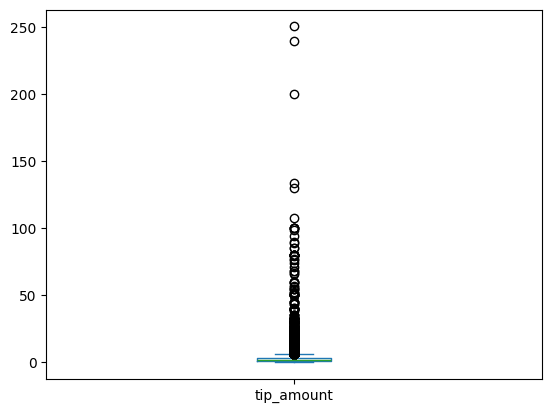

ValueError: Must specify axis=0 or 1

In [31]:
y_train.plot(kind='box')
plt.savefig('example_green_taxi_tip_amount_boxplot.svg', format='svg')
plt.show()

y_train.clip(lower=0, upper=y_train.quantile(0.8)).to_frame().hist()
plt.savefig('example_green_taxi_tip_amount_distribution.svg', format='svg')
plt.show()


In [32]:
model = LGBMRegressor(random_state=111)
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005061 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 885
[LightGBM] [Info] Number of data points in the train set: 141568, number of used features: 6
[LightGBM] [Info] Start training from score 2.363484


In [ ]:
# y_pred_train_baseline = np.ones_like(y_train) * y_train.mean()
# y_pred_test_baseline = np.ones_like(y_test) * y_train.mean()

# mae_train = mean_absolute_error(y_train, y_pred_train).round(4)
# mae_test = mean_absolute_error(y_test, y_pred_test).round(4)

# mae_train_baseline = mean_absolute_error(y_train, y_pred_train_baseline).round(4)
# mae_test_baseline = mean_absolute_error(y_test, y_pred_test_baseline).round(4)

In [35]:
y_pred_prod = model.predict(X_val)

In [36]:
reference_df = X_test.copy() # using the test set as a reference
reference_df['y_pred'] = y_pred_test # reference predictions
reference_df['tip_amount'] = y_test # ground truth (currect targets)
reference_df = reference_df.join(data['lpep_pickup_datetime']) # date

analysis_df = X_val.copy() # features
analysis_df['y_pred'] = y_pred_prod # prod predictions
analysis_df = analysis_df.join(data['lpep_pickup_datetime']) # date

In [42]:
reference_df

,pulocationid,dolocationid,trip_distance,vendorid,fare_amount,pickup_time,y_pred,tip_amount,lpep_pickup_datetime
0,40,229,7.48,2,26.0,22,4.602886,5.46,2016-12-01 00:00:02
4,112,36,7.60,1,32.5,4,5.338349,6.75,2016-12-01 00:00:25
7,145,137,2.76,2,13.0,9,2.411991,3.87,2016-12-01 00:00:44
11,166,74,1.74,2,10.0,13,1.654694,0.00,2016-12-01 00:00:52
12,116,151,2.65,2,9.0,9,1.663490,0.00,2016-12-01 00:00:53
...,...,...,...,...,...,...,...,...,...
581826,145,112,3.35,2,14.0,7,2.564025,0.00,2016-12-31 23:59:11
581827,244,42,3.75,2,12.0,21,2.363946,1.00,2016-12-31 23:59:20
581828,33,113,3.13,2,13.0,9,2.552242,2.76,2016-12-31 23:59:31
581831,7,163,3.35,2,13.5,20,2.604810,1.00,2016-12-31 23:59:49


In [41]:
features = []
for f in fv.features:
    features.append(f.name)

print(features)

['pulocationid', 'dolocationid', 'trip_distance', 'vendorid', 'fare_amount', 'tip_amount', 'pickup_time']


In [43]:
dle = nml.DLE(
    metrics=['mae'],
    y_true='tip_amount',
    y_pred='y_pred',
    feature_column_names=features,
    timestamp_column_name='lpep_pickup_datetime',
    chunk_period='d' # perform an estimation daily
)

dle.fit(reference_df) # fit on the reference (test) data
estimated_performance = dle.estimate(analysis_df) # estimate on the prod data

2025-04-14 00:05:17,784 INFO: fitting DLE[tune_hyperparameters=False, metrics=['MAE']]
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001631 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1422
[LightGBM] [Info] Number of data points in the train set: 270052, number of used features: 8
[LightGBM] [Info] Start training from score 1.062954
2025-04-14 00:05:19,162 INFO: estimating DLE[tune_hyperparameters=False, metrics=['MAE']]


CalculatorException: failed while calculating DLE[tune_hyperparameters=False, metrics=['MAE']].
'tip_amount'